# __Exploratory Data Analysis (EDA)__
_Projet Analyse de sentiments — Exploration initiale des tweets_


In [1]:
import sys
import os

# On ajoute le chemin absolu vers src/
sys.path.append(os.path.abspath(".."))

import mlflow
from src.utils.tracking import log_run


# On fixe l'emplacement centralisé des logs MLflow (remonte d'un cran car le notebook est dans /notebooks/)
mlflow.set_tracking_uri("file:../mlruns")

# On déclare (ou crée si nécessaire) l'expérience
mlflow.set_experiment("Projet7-Sentiment")

# Exemple de paramètres et métriques fictifs
params = {"C": 1.0, "penalty": "l2"}
metrics = {"accuracy": 0.82, "f1": 0.79}

# Lancement d’un premier run de test
log_run("Test-LogisticRegression", params, metrics)



## __Documentation du jeu de données brut__

Le fichier brut `training.1600000.processed.noemoticon.csv` contient __6 colonnes__ :  

- __0 : sentiment__ — valeur binaire (`0 = négatif`, `4 = positif`)  
- __1 : id__ — identifiant unique du tweet  
- __2 : date/heure__ — horodatage de la publication  
- __3 : query__ — champ lié à la recherche (souvent `"NO_QUERY"`)  
- __4 : username__ — nom d’utilisateur Twitter  
- __5 : text__ — contenu textuel du tweet  

### Pipeline appliqué pour générer les données traitées
- Lecture du CSV brut avec l’encodage `latin-1`  
- Sélection des colonnes __0__ et __5__ → renommage en `label` et `text`  
- Filtrage des lignes vides et normalisation minimale du texte  
- Sauvegarde du jeu de données nettoyé au format __parquet__ dans `data/processed/tweets.parquet`  

Ce pipeline permet de simplifier le dataset pour se concentrer uniquement sur les textes et leurs labels (positif/négatif).


In [2]:
import pandas as pd

# Chemins vers les fichiers de données
# (non versionnés pour le brut, versionnés pour le traité)
SOURCE_RAW = "../data/raw/training.1600000.processed.noemoticon.csv"  # fichier brut (non versionné)
SOURCE_PROCESSED = "../data/processed/tweets.parquet"                 # dérivé utilisé pour l'EDA

print("Données brutes (non chargées ici) :", SOURCE_RAW)
print("Données traitées (chargées)       :", SOURCE_PROCESSED)


Données brutes (non chargées ici) : ../data/raw/training.1600000.processed.noemoticon.csv
Données traitées (chargées)       : ../data/processed/tweets.parquet


In [3]:
# Charger le fichier parquet optimisé
df = pd.read_parquet("../data/processed/tweets.parquet")

# Aperçu des données
df.head()


,label,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


## __Dimensions du dataset__


In [4]:
df.shape


(1600000, 2)

## __Répartition des labels__


In [5]:
df['label'].value_counts(normalize=True)


label
0    0.5
4    0.5
Name: proportion, dtype: float64

## __Statistiques sur la longueur des tweets__


In [6]:
df['len'] = df['text'].str.len()
df['len'].describe()


count    1.600000e+06
mean     7.409011e+01
std      3.644114e+01
min      6.000000e+00
25%      4.400000e+01
50%      6.900000e+01
75%      1.040000e+02
max      3.740000e+02
Name: len, dtype: float64

In [7]:
# Aperçu types et valeurs manquantes
display(df.dtypes)
display(df.isna().sum().sort_values(ascending=False))

# Vérification du domaine de labels
labels_uniques = sorted(df["label"].unique().tolist())
print("Labels uniques :", labels_uniques)
assert set(labels_uniques).issubset({0,4}), "Les labels ne sont pas uniquement {0,4}."

# Doublons (au cas où)
nb_dupl_text = df["text"].duplicated().sum()
print("Doublons sur 'text' :", nb_dupl_text)


label     int64
text     object
len       int64
dtype: object

label    0
text     0
len      0
dtype: int64

Labels uniques : [0, 4]
Doublons sur 'text' : 18534


## __Création d'un dictionnaire de données__

Un dictionnaire de données (ou data dictionary) est un document qui décrit chaque colonne du dataset.  
Il répond à trois objectifs :
- __Compréhension__ : savoir exactement ce que contient chaque champ (utile pour le créateur, mais aussi pour le lecteur).
- __Communication__ : si quelqu’un d’autre reprend ton projet, il/elle peut comprendre la structure des données sans replonger dans le CSV.
- __Traçabilité__ : noter les décisions (par ex. « colonne X supprimée car redondante »).

In [8]:
import pandas as pd
import numpy as np

def safe_example(series, max_len=80):
    if series.empty:
        return ""
    x = series.iloc[0]
    if pd.isna(x):
        return ""
    x = str(x)
    return x[:max_len] + ("..." if len(x) > max_len else "")

# Métriques globales utiles
missing = df.isna().mean().to_dict()
nunique = df.nunique(dropna=True).to_dict()

# Dictionnaire de base
dico = []

# label
if "label" in df.columns:
    dico.append({
        "colonne": "label",
        "type": str(df["label"].dtype),
        "description": "Sentiment binaire (0 = négatif, 4 = positif)",
        "exemple": "" if df.empty else int(df["label"].iloc[0]),
        "%missing": round(100*missing.get("label", 0), 2),
        "n_uniques": int(nunique.get("label", 0))
    })

# text
if "text" in df.columns:
    dico.append({
        "colonne": "text",
        "type": str(df["text"].dtype),
        "description": "Contenu textuel du tweet (anglais)",
        "exemple": safe_example(df["text"]),
        "%missing": round(100*missing.get("text", 0), 2),
        "n_uniques": int(nunique.get("text", 0))
    })

# colonnes dérivées éventuelles
for c, desc in [
    ("len", "Longueur (nb de caractères) calculée"),
    # ("num_urls", "Nombre d'URL détectées"),
    # ("num_mentions", "Nombre de mentions détectées"),
]:
    if c in df.columns:
        dico.append({
            "colonne": c,
            "type": str(df[c].dtype),
            "description": desc,
            "exemple": "" if df.empty else df[c].iloc[0],
            "%missing": round(100*missing.get(c, 0), 2),
            "n_uniques": int(nunique.get(c, 0))
        })

# DataFrame propre avec colonnes ordonnées
cols_order = ["colonne", "type", "description", "exemple", "%missing", "n_uniques"]
data_dict = pd.DataFrame(dico)[cols_order]
display(data_dict)

# Exports
data_dict_path_csv = "../reports/data_dictionary.csv"
data_dict_path_md  = "../reports/data_dictionary.md"

data_dict.to_csv(data_dict_path_csv, index=False)

with open(data_dict_path_md, "w", encoding="utf-8") as f:
    f.write("# Data Dictionary\n\n")
    for _, r in data_dict.iterrows():
        f.write(f"## {r['colonne']}\n")
        f.write(f"- Type : `{r['type']}`\n")
        f.write(f"- Description : {r['description']}\n")
        f.write(f"- Exemple : {r['exemple']}\n")
        f.write(f"- % manquants : {r['%missing']}%\n")
        f.write(f"- Nb. valeurs uniques : {r['n_uniques']}\n\n")

print("Exporté :", data_dict_path_csv, "et", data_dict_path_md)


,colonne,type,description,exemple,%missing,n_uniques
0,label,int64,"Sentiment binaire (0 = négatif, 4 = positif)",0,0.0,2
1,text,object,Contenu textuel du tweet (anglais),"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0.0,1581466
2,len,int64,Longueur (nb de caractères) calculée,115,0.0,257


Exporté : ../reports/data_dictionary.csv et ../reports/data_dictionary.md


## __Gestion des doublons__

Objectif : nettoyer les doublons avant l’EDA.
1) __Supprimer complètement__ les textes __contradictoires__ (même `text` avec des `label` différents).
2) Sur le reste, __garder la première occurrence__ pour chaque doublon __(même `text` et même `label`)__.

Cette décision vise à éviter d’introduire du bruit (contradictions) et à réduire les répétitions exactes qui n’apportent pas d’information supplémentaire au modèle.

In [9]:
# Nombre de doublons exacts sur la colonne text
nb_duplicated = df["text"].duplicated().sum()
print(f"Nombre de doublons détectés dans text : {nb_duplicated}")


Nombre de doublons détectés dans text : 18534


In [10]:
# Compter les occurrences par texte et garder ceux avec au moins 2 occurrences
dup_counts = (
    df.groupby("text", dropna=False)
      .size()
      .reset_index(name="count")
      .sort_values("count", ascending=False)
)

dup_counts_head = dup_counts[dup_counts["count"] > 1].head(20)
dup_counts_head


,text,count
1416158,isPlayer Has Died! Sorry,210
1312365,good morning,118
1333240,headache,115
843182,Good morning,112
870665,Headache,106
3166,"cant afford to see Angels and Demons, so i wa...",86
1069563,"Not to worry, noone got that one. Next questio...",86
847272,Goodnight,85
1462471,my tummy hurts,81
993586,"Jogging, isnt REALLY that cool, especially if ...",80


In [11]:
# Textes qui apparaissent avec plusieurs labels (incohérences)
multi_label = (
    df.groupby("text")["label"]
      .nunique()
      .reset_index(name="n_labels")
      .query("n_labels > 1")
)

print(f"Textes avec labels contradictoires : {len(multi_label)}")

# Voir quelques exemples contradictoires
if len(multi_label) > 0:
    sample_contra = (
        df.merge(multi_label[["text"]], on="text", how="inner")
          .sort_values("text")
          .head(50)
    )
    sample_contra


Textes avec labels contradictoires : 2225


In [12]:
# ---- paramètres de sortie
OUT_PATH = "../data/processed/tweets_clean.parquet"  # nouveau fichier traité

# ---- 0) sauvegarder la taille initiale
n0 = df.shape[0]

# ---- 1) détecter les textes contradictoires (même text, plusieurs labels)
multi_label = (
    df.groupby("text")["label"]
      .nunique(dropna=False)
      .reset_index(name="n_labels")
      .query("n_labels > 1")
)

n_contra_texts = multi_label.shape[0]

# Vérification :
EXPECTED_CONTRADICTORY = 2225
print(f"Textes contradictoires détectés : {n_contra_texts}")
if EXPECTED_CONTRADICTORY and n_contra_texts != EXPECTED_CONTRADICTORY:
    print(f"⚠️ Note : tu attendais {EXPECTED_CONTRADICTORY}, on a trouvé {n_contra_texts}. (info, pas bloquant)")

# ---- 2) supprimer TOUTES les lignes dont le 'text' fait partie des contradictoires
df_no_contra = df[~df["text"].isin(multi_label["text"])].copy()
n_after_contra = df_no_contra.shape[0]
removed_contra_rows = n0 - n_after_contra

print(f"Lignes supprimées car 'text' contradictoire : {removed_contra_rows} (sur {n0})")
print(f"Taille après suppression des contradictoires : {df_no_contra.shape}")

# ---- 3) supprimer ensuite les doublons exacts (même text ET même label), garder la première occurrence
df_clean = df_no_contra.drop_duplicates(subset=["text", "label"], keep="first").copy()
n_final = df_clean.shape[0]
removed_exact_dups = n_after_contra - n_final
pct_reduc_total = 100 * (1 - n_final / n0)

print(f"Doublons exacts (text+label) supprimés : {removed_exact_dups}")
print(f"Taille finale : {df_clean.shape}  |  Réduction totale : {pct_reduc_total:.2f}%")

# ---- 4) enregistrer la version nettoyée
df_clean.to_parquet(OUT_PATH, index=False)
print(f"Export parquet : {OUT_PATH}")


Textes contradictoires détectés : 2225
Lignes supprimées car 'text' contradictoire : 6895 (sur 1600000)
Taille après suppression des contradictoires : (1593105, 3)
Doublons exacts (text+label) supprimés : 13864
Taille finale : (1579241, 3)  |  Réduction totale : 1.30%
Export parquet : ../data/processed/tweets_clean.parquet


In [13]:
# Centraliser les logs au niveau racine du projet (le notebook est dans /notebooks/)
mlflow.set_tracking_uri("file:../mlruns")
mlflow.set_experiment("Projet7-Sentiment")

metrics = {
    "n_rows_initial": int(n0),
    "n_texts_contradictoires": int(n_contra_texts),
    "n_rows_apres_contra": int(n_after_contra),
    "n_rows_final": int(n_final),
    "n_rows_removed_contra": int(removed_contra_rows),
    "n_rows_removed_exact_dups": int(removed_exact_dups),
    "pct_reduction_total": float(pct_reduc_total),
}
params = {
    "rule_contradictions": "drop ALL rows for texts with multiple labels",
    "rule_exact_duplicates": "drop_duplicates(subset=['text','label'], keep='first')",
    "output_path": OUT_PATH,
}

log_run("CLEAN_DUPLICATES_STEP1", params=params, metrics=metrics)
print("MLflow: décision de déduplication loggée.")


MLflow: décision de déduplication loggée.


## __Exploration des données texte__

In [14]:
# Exploration des données texte
# Import des bibliothèques nécessaires
import pandas as pd
import numpy as np
import seaborn as sns
import nltk
import spacy
import matplotlib.pyplot as plt
import tensorflow as tf


label
0    800000
4    800000
Name: count, dtype: int64


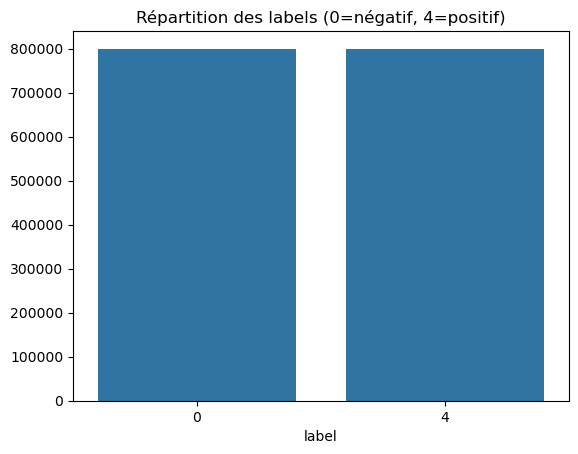

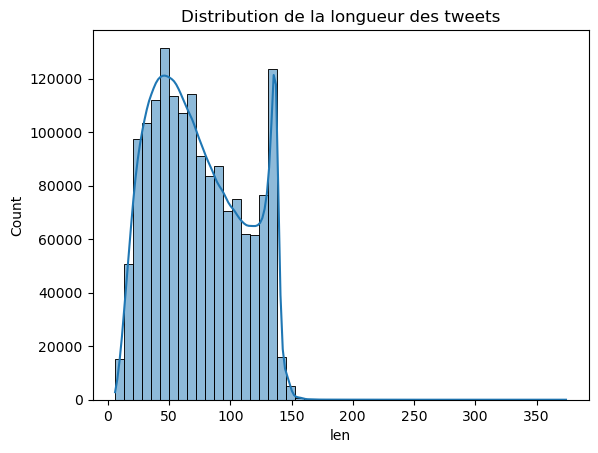

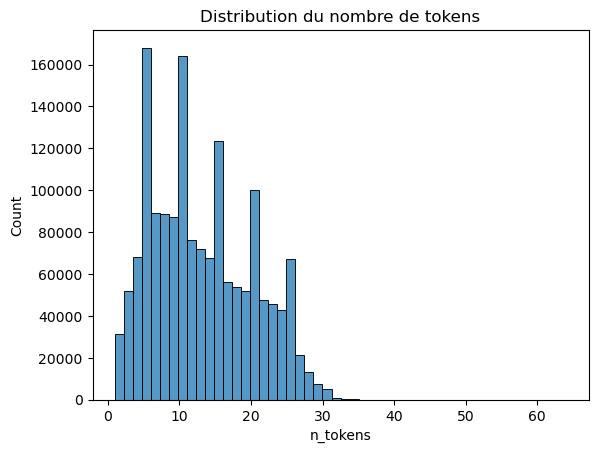

has_url        0.043864
has_mention    0.466520
has_hashtag    0.023008
dtype: float64

--- Exemples négatifs ---
["@xnausikaax oh no! where did u order from? that's horrible ", 'A great hard training weekend is over.  a couple days of rest and lets do it again!  Lots of computer time to put in now ', "Right, off to work  Only 5 hours to go until I'm free xD", 'I am craving for japanese food ', 'Jean Michel Jarre concert tomorrow  gotta work 7-3 before though ']

--- Exemples positifs ---
['Is lookin 4ward to a long weekend  really dont want to go to work 2day tho =[ x', '#myweakness  Is music and i live to meet the people who make it ', 'figured out the Internet on my new iPod ', "@hillsongunited can't wait to worship with you guys tonight. it'll be so much fun ", "@sillybeggar Congrats James !! I'm sure the book is going to be a huge success "]


In [15]:
# --- Étape 2 : Exploration des données texte ---

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Stats sur les labels
label_counts = df["label"].value_counts()
print(label_counts)
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title("Répartition des labels (0=négatif, 4=positif)")
plt.show()

# 2. Longueur des tweets
sns.histplot(df["len"], bins=50, kde=True)
plt.title("Distribution de la longueur des tweets")
plt.show()

# 3. Nb de tokens
df["n_tokens"] = df["text"].str.split().apply(len)
sns.histplot(df["n_tokens"], bins=50, kde=False)
plt.title("Distribution du nombre de tokens")
plt.show()

# 4. Analyse simple sur ponctuation/URLs/mentions
df["has_url"] = df["text"].str.contains("http")
df["has_mention"] = df["text"].str.contains("@")
df["has_hashtag"] = df["text"].str.contains("#")

print(df[["has_url", "has_mention", "has_hashtag"]].mean())

# 5. Quelques exemples de tweets
print("\n--- Exemples négatifs ---")
print(df[df["label"] == 0]["text"].sample(5, random_state=42).to_list())

print("\n--- Exemples positifs ---")
print(df[df["label"] == 4]["text"].sample(5, random_state=42).to_list())


__Vérifications des données__

- label :
    - 800 000 négatifs (0)
    - 800 000 positifs (4)
→ Dataset parfaitement équilibré 

- Features ajoutées :
    - `has_url` : ≈ 4.4% des tweets contiennent un lien
    - `has_mention` : ≈ 46.6% des tweets mentionnent quelqu’un
    - `has_hashtag` : ≈ 2.3% des tweets contiennent un hashtag

- Visualisations :
    - Histogrammes et barplots ont bien fonctionné (les Figure size 640x480 confirment l’affichage des graphes).
    - Répartition équilibrée entre labels, distribution de longueurs de textes et fréquence des features.

- Exemples :
    - Négatifs → contiennent frustration, contraintes, et des sentiments partagés.
    - Positifs → anticipation, joie, succès, encouragement et sentiments partagés.
→ Sélection plutôt cohérente avec le label.

## __Sous-échantillon pour prototypage__
- Objectif : accélérer l’itération (prétraitement + baselines) sans saturer la machine.
- Méthode : échantillon stratifié __16 000 tweets__ (8 000 négatifs, 8 000 positifs) depuis le dataset nettoyé des doublons.
- Fichiers :
  - Entrée : `data/processed/tweets_clean.parquet`
  - Sortie : `data/processed/tweets_16k.parquet`
- Le jeu complet restera utilisé plus tard (optimisation et modèles avancés).



In [16]:
from pathlib import Path

IN_PATH  = "../data/processed/tweets_clean.parquet"
OUT_PATH = "../data/processed/tweets_16k.parquet"
SEED     = 42
N_PER_LABEL = 8000  # 8k par classe → 16k total

df_full = pd.read_parquet(IN_PATH)

# vérif classes
print(df_full["label"].value_counts())

# stratification simple : même nombre par classe
df_16k = (
    df_full
    .groupby("label", group_keys=False)
    .apply(lambda g: g.sample(n=N_PER_LABEL, random_state=SEED))
    .reset_index(drop=True)
)

print(df_16k.shape, df_16k["label"].value_counts())

# sauvegarde
Path("../data/processed").mkdir(parents=True, exist_ok=True)
df_16k.to_parquet(OUT_PATH, index=False)
print("Export échantillon :", OUT_PATH)


label
4    791281
0    787960
Name: count, dtype: int64
(16000, 3) label
0    8000
4    8000
Name: count, dtype: int64
Export échantillon : ../data/processed/tweets_16k.parquet


/var/folders/zt/cgsq3wl14cz2fvg9pccn_g1r0000gn/T/ipykernel_17274/3602538096.py:17: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(n=N_PER_LABEL, random_state=SEED))


## __Prétraitement NLP sur l’échantillon 16k__

- Entrée : `data/processed/tweets_16k.parquet` (8k négatifs, 8k positifs).
- Étapes :
  1) Nettoyage (lower, URLs, @, #, HTML, non-alpha)
  2) Normalisation d'emojis via `emoji.demojize()`: deux variantes sont conservées pour comparaison.
  3) __Tokenisation__ + retraits de stopwords (→ `tokens`)
  4) __Lemmatisation__ spaCy (→ `lemmas`)
  5) Texte final pour vectorisation (→ `text_clean`)
- Optimisation : `nlp.pipe(..., batch_size, n_process)` pour paralléliser la lemmatisation.
- Sortie : `data/processed/tweets_16k_clean.parquet` et `data/processed/tweets_16k_clean_emoji.parquet`.

__Décisions__ :
- Conserver la __négation__ (`not`, `no`, `nor`, `n't`) car signal fort pour le sentiment.
- Gérer les __contractions__ (don't → do not) avant tokenisation pour stabiliser les bigrammes (_not good_).
- Limiter les __allongements__ (soooo → soo) pour réduire le bruit.
- Normaliser les __emojis__ (🙂 → :slightly_smiling_face:) et laisser passer `:tokens_emoji:`.
- Mettre dans un __transformer sklearn__ réutilisable pour `Pipeline`/`GridSearchCV`.

Colonnes conservées à des fins pédagogiques :
- `text_clean_base`, `text_clean_base_emoji`, `tokens`, `lemmas`, `text_clean`, `tokens_emoji`, `text_clean_emoji`.


In [17]:
import os, nltk

# Dossier local (dans ton HOME) où NLTK va stocker les données
NLTK_DIR = os.path.expanduser("~/nltk_data")
os.makedirs(NLTK_DIR, exist_ok=True)

# S'assurer que NLTK regarde dans ce dossier
if NLTK_DIR not in nltk.data.path:
    nltk.data.path.append(NLTK_DIR)

# Télécharger (silencieusement) ce qui manque
for pkg in ["stopwords", "punkt", "wordnet"]:
    try:
        nltk.data.find(f"corpora/{pkg}")
    except LookupError:
        nltk.download(pkg, download_dir=NLTK_DIR, quiet=True)

# Test : construire la liste de stopwords
from nltk.corpus import stopwords
stop_en = set(stopwords.words('english'))
print(f"Stopwords chargés : {len(stop_en)} mots")


Stopwords chargés : 198 mots


In [18]:
import re
from typing import List

# --- Charger l'échantillon 16k ---
df = pd.read_parquet("../data/processed/tweets_16k.parquet")
print("Shape sample:", df.shape, "| labels:\n", df["label"].value_counts())

# --- NLTK stopwords ---
import nltk
from nltk.corpus import stopwords
# Assure-toi d'avoir fait une fois:
# import nltk; nltk.download('stopwords'); nltk.download('punkt')
stop_en = set(stopwords.words('english'))

# --- spaCy (lemmatisation) ---
import spacy
try:
    nlp = spacy.load("en_core_web_sm", disable=["ner","parser"])
except OSError:
    # !python -m spacy download en_core_web_sm
    nlp = spacy.load("en_core_web_sm", disable=["ner","parser"])

# --- 1) Nettoyage de base (regex) ---
url_pat      = re.compile(r"https?://\S+|www\.\S+")
mention_pat  = re.compile(r"@\w+")
hashtag_pat  = re.compile(r"#\w+")
html_pat     = re.compile(r"&\w+;")        # entités html
nonalpha_pat = re.compile(r"[^a-zA-Z\s]")  # garde lettres et espaces

def clean_basic(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = text.lower()
    t = url_pat.sub(" ", t)
    t = mention_pat.sub(" ", t)
    t = hashtag_pat.sub(" ", t)
    t = html_pat.sub(" ", t)
    t = nonalpha_pat.sub(" ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

df["text_clean_base"] = df["text"].apply(clean_basic)

# Option emoji -> transforme 🙂 en ":slightly_smiling_face:"
try:
    import emoji
    def normalize_emoji(t: str) -> str:
        return emoji.demojize(t, language="en")
except Exception:
    # fallback si le paquet n'est pas installé
    def normalize_emoji(t: str) -> str:
        return t

url_pat      = re.compile(r"https?://\S+|www\.\S+")
mention_pat  = re.compile(r"@\w+")
hashtag_pat  = re.compile(r"#\w+")
html_pat     = re.compile(r"&\w+;")
nonalpha_pat = re.compile(r"[^a-zA-Z\s:_]")  # on garde ":" et "_" pour les :smiling_face:

def clean_basic_with_emoji(text: str) -> str:
    if not isinstance(text, str):
        return ""
    t = normalize_emoji(text)      # 👉 étape ajoutée
    t = t.lower()
    t = url_pat.sub(" ", t)
    t = mention_pat.sub(" ", t)
    t = hashtag_pat.sub(" ", t)
    t = html_pat.sub(" ", t)
    t = nonalpha_pat.sub(" ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

# Nous ajoutons une nouvelle colonne pour le texte nettoyé avec les emojis
df["text_clean_base_emoji"] = df["text"].apply(clean_basic_with_emoji)

# --- 2) Tokenisation + retrait stopwords (NLTK) ---
def tokenize_and_filter(text: str) -> List[str]:
    toks = text.split()  # simple et efficace après clean_basic
    toks = [w for w in toks if (w not in stop_en and len(w) > 2)]
    return toks

df["tokens"] = df["text_clean_base"].apply(tokenize_and_filter)
df["tokens_emoji"] = df["text_clean_base_emoji"].apply(tokenize_and_filter)


# --- 3) Lemmatisation (spaCy) : même logique mais accélérée via nlp.pipe ---
# On évite d'appeler nlp() pour chaque ligne (lent) ; on passe par pipe en lots/parallèle.
texts_for_lemma = df["tokens"].apply(lambda xs: " ".join(xs)).tolist()

lemmas_list = []
# Ajuste batch_size / n_process à ta machine (M4 Max → 4 à 6 process OK)
for doc in nlp.pipe(texts_for_lemma, batch_size=1000, n_process=4):
    lemmas = [t.lemma_ for t in doc if t.is_alpha and not t.is_stop and len(t.lemma_) > 2]
    lemmas_list.append(lemmas)

df["lemmas"] = lemmas_list

texts_for_lemma_emoji = df["tokens_emoji"].apply(lambda xs: " ".join(xs)).tolist()
lemmas_list_emoji = []
for doc in nlp.pipe(texts_for_lemma_emoji, batch_size=1000, n_process=4):
    lemmas = [t.lemma_ for t in doc if t.is_alpha and not t.is_stop and len(t.lemma_) > 2]
    lemmas_list_emoji.append(lemmas)

df["lemmas_emoji"] = lemmas_list_emoji

# --- 4) Texte final (pour TF-IDF / CountVectorizer) : identique ---
df["text_clean"] = df["lemmas"].apply(lambda xs: " ".join(xs))
df["text_clean_emoji"] = df["lemmas_emoji"].apply(lambda xs: " ".join(xs))

# --- 5) Sanity checks (affichage identique) ---
print("Avant / Après (5 exemples) :")
display(
    df[["text","text_clean_base","text_clean_base_emoji","tokens","tokens_emoji","lemmas","text_clean","text_clean_emoji"]]
      .sample(5, random_state=42)
)

# --- 6) Export de l'échantillon prétraité ---
out_path = "../data/processed/tweets_16k_clean.parquet"
Path("../data/processed").mkdir(parents=True, exist_ok=True)
df.to_parquet(out_path, index=False)
print("Export :", out_path)


Shape sample: (16000, 3) | labels:
 label
0    8000
4    8000
Name: count, dtype: int64
Avant / Après (5 exemples) :


,text,text_clean_base,text_clean_base_emoji,tokens,tokens_emoji,lemmas,text_clean,text_clean_emoji
8756,It's 1:39 am and I'm home. My changed the kitc...,it s am and i m home my changed the kitchen ar...,it s : am and i m home my changed the kitchen ...,"[home, changed, kitchen, around, hope, right, ...","[home, changed, kitchen, around, hope, right, ...","[home, change, kitchen, hope, right, apartment]",home change kitchen hope right apartment,home change kitchen hope right apartment
4660,@laur945 Thanks m'dear! I'll need it. I partic...,thanks m dear i ll need it i particularly hate...,thanks m dear i ll need it i particularly hate...,"[thanks, dear, need, particularly, hate, helic...","[thanks, dear, need, particularly, hate, helic...","[thank, dear, need, particularly, hate, helico...",thank dear need particularly hate helicopter p...,thank dear need particularly hate helicopter p...
6095,"Just driven past a race team base, and it had ...",just driven past a race team base and it had a...,just driven past a race team base and it had a...,"[driven, past, race, team, base, space, availa...","[driven, past, race, team, base, space, availa...","[drive, past, race, team, base, space, availab...",drive past race team base space available sign,drive past race team base space available sign
304,"Stuck at my parents, worried about work &amp; ...",stuck at my parents worried about work my car ...,stuck at my parents worried about work my car ...,"[stuck, parents, worried, work, car, broken]","[stuck, parents, worried, work, car, broken]","[stick, parent, worry, work, car, break]",stick parent worry work car break,stick parent worry work car break
8241,@mariangel_ cool what grade are you now?,cool what grade are you now,cool what grade are you now,"[cool, grade]","[cool, grade]","[cool, grade]",cool grade,cool grade


Export : ../data/processed/tweets_16k_clean.parquet


In [19]:
mlflow.set_tracking_uri("file:../mlruns")
mlflow.set_experiment("Projet7-Sentiment")

metrics = {
    "n_rows_sample": int(df.shape[0]),
    "avg_tokens": float(df["tokens"].apply(len).mean()),
    "avg_lemmas": float(df["lemmas"].apply(len).mean()),
}
params = {
    "sample": "16k (8k/8k)",
    "clean": "lower+remove urls/@/#/html + keep alpha",
    "stopwords": "nltk english",
    "lemmatizer": "spacy en_core_web_sm via nlp.pipe(batch=1000, n_process=4)",
    "output": "tweets_16k_clean.parquet",
}

log_run("PREPROCESS_16K", params=params, metrics=metrics)
print("MLflow: PREPROCESS_16K loggé.")

mlflow.set_tracking_uri("file:../mlruns")
mlflow.set_experiment("Projet7-Sentiment")

metrics = {
    "n_rows": int(df.shape[0]),
    "avg_tokens_base": float(df["tokens"].apply(len).mean()),
    "avg_tokens_emoji": float(df["tokens_emoji"].apply(len).mean()),
    "avg_lemmas": float(df["lemmas"].apply(len).mean()),
}
params = {
    "sample": "16k",
    "clean_base": "lower + remove urls/@/#/html + keep alpha",
    "emoji_norm": "emoji.demojize (en) → text_clean_base_emoji",
    "tokenizer": "split() + stopwords(NLTK english) + len>2",
    "lemmatizer": "spaCy en_core_web_sm via nlp.pipe(batch=1000, n_process=4)",
    "outputs": "text_clean, text_clean_emoji (si créé)",
}

log_run("PREPROCESS_16K_EMOJI", params=params, metrics=metrics)
print("MLflow: PREPROCESS_16K_EMOJI loggé.")



MLflow: PREPROCESS_16K loggé.
MLflow: PREPROCESS_16K_EMOJI loggé.


In [20]:
df.to_parquet("../data/processed/tweets_16k_clean_emoji.parquet", index=False)
